Your Name and PRN:
- Name: ______________________
- PRN : ______________________
- Date: ______________________

# Image Processing with Neural Network
## Assignment A05

## Tensor Flow
- Select number of layers
- Select node in each of the layers
- Choose activation function
- multi-class - Fashion MNIST dataset (all 60000 images)
- Implement one or more of following to achieve max accuracy.
    - L1/ L2 Regularization
    - Dropout
    - Batch Normalization
    - Early stopping
- Save model

In [3]:
#!/usr/bin/env pyhton3
# -*- coding 

from sklearn import datasets
from sklearn.model_selection import train_test_split
###-----------------
### Import Libraries
###-----------------
import os
import time
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix
import gc
import torch.nn as nn
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

import tensorflow as tf
from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Introduction to tensorFlow Fashion  dataset
- multi class
- reLU
- swish


In [6]:
# Global variables
inpDir = './input' # Input Stored here
outDir = './ouput' # output Here
modelDir = './models'# to save Models
subDir = 'fashion_mnist' # sub dir by dataset
RANDOM_STATE = 24
np.random.RandomState(seed = RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
#rng = np.random.default_rng(seed = RANDOM_STATE)
#N_SAMPLE = 1000
TEST_SIZE = 0.2 # 18147 - 56*256
ALPHA = 0.001 # learning rate
NOISE = 0.2 # Error
EPOCHS = 100
BATCH_SIZE = 32

PATIENCE = 30
LR_FACTOR  =0.1
LR_PATIENCE = 20

In [7]:
# tf.random.set_seed?


In [8]:
# inpDir = './input'
# outDir = './output'

In [9]:
#set the plotting parameters
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }
    #'text.usetex':True,

plt.rcParams.update(params)
CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid')


## Load Fashion MNIST dataset


This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing you'll use here.

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

Here, 60,000 images are used to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow. Import and [load the Fashion MNIST data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data) directly from TensorFlow:

In [11]:
# train_df = pd.read_csv(os.path.join(inpDir,'fashion-mnist_train.csv'))

In [12]:
def fn_plot_torch_hist(hist_df):
    
    # instantiate figure
    fig, axes = plt.subplots(1,2 , figsize = (15,6))
    
    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='cyan', alpha=0.5)

    # columns
    x = hist_df.columns[0]
    y1 = hist_df.columns[1]
    y2 = hist_df.columns[2]
    y3 = hist_df.columns[3]
    y4 = hist_df.columns[4]
    
    # Where was min loss
    best = hist_df[hist_df[y2] == hist_df[y2].min()]
    best = best.drop_duplicates(subset='test_loss')
    # pick first axis
    ax = axes[0]

    # Plot all losses
    hist_df.plot(x = x, y = [y1, y2], ax = ax)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y2].min())
    y_max = max(hist_df[y1].max(), hist_df[y2].max())
    offset = (y_max-y_min)/10.0

    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y2]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y2].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y2].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()+ offset, best[y2].to_numpy()[0]+offset), # location of text 
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow
    
    # Draw vertical line at best value
    ax.axvline(x = best[x].to_numpy(), color = 'green', linestyle='-.', lw = 3);
    
    ax.set_xlabel(x.title())
    ax.set_ylabel(y1.title())
    ax.set_title('Errors')
    ax.grid(True)
    ax.legend(loc = 'upper left') # model legend to upper left

    # pick second axis
    ax = axes[1]

    # Plot accuracies
    hist_df.plot(x = x, y = [y3, y4], ax = ax)

    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y3],
                           hist_df.iloc[-1][y4]) #text to plot
        
    # calculate offset for arroe
    y_min = min(hist_df[y3].min(), hist_df[y4].min())
    y_max = max(hist_df[y3].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # place a text box in lower middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()- offset, best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow
    
    
    # Draw a vertical line at best value
    ax.axvline(x = best[x].to_numpy(), 
               color = 'green', 
               linestyle='-.', lw = 3)
    
    # Labels
    ax.set_xlabel(x.title())
    ax.set_ylabel(y3.title())
    ax.set_title('Accuracies')
    ax.grid(True)
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()



In [13]:
train_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_train.csv')
test_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_test.csv')

train_df = pd.read_csv(train_filename, header = 0)
test_df = pd.read_csv(test_filename, header = 0)

In [14]:
train_df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
train_df.isnull().sum().sum(), test_df.isnull().sum().sum()

(0, 0)

In [17]:
#class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

class_names = {0: 'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',
               5:'Sandal', 6: 'Shirt',7: 'Sneaker', 8:'Bag', 9: 'Ankle boot'}

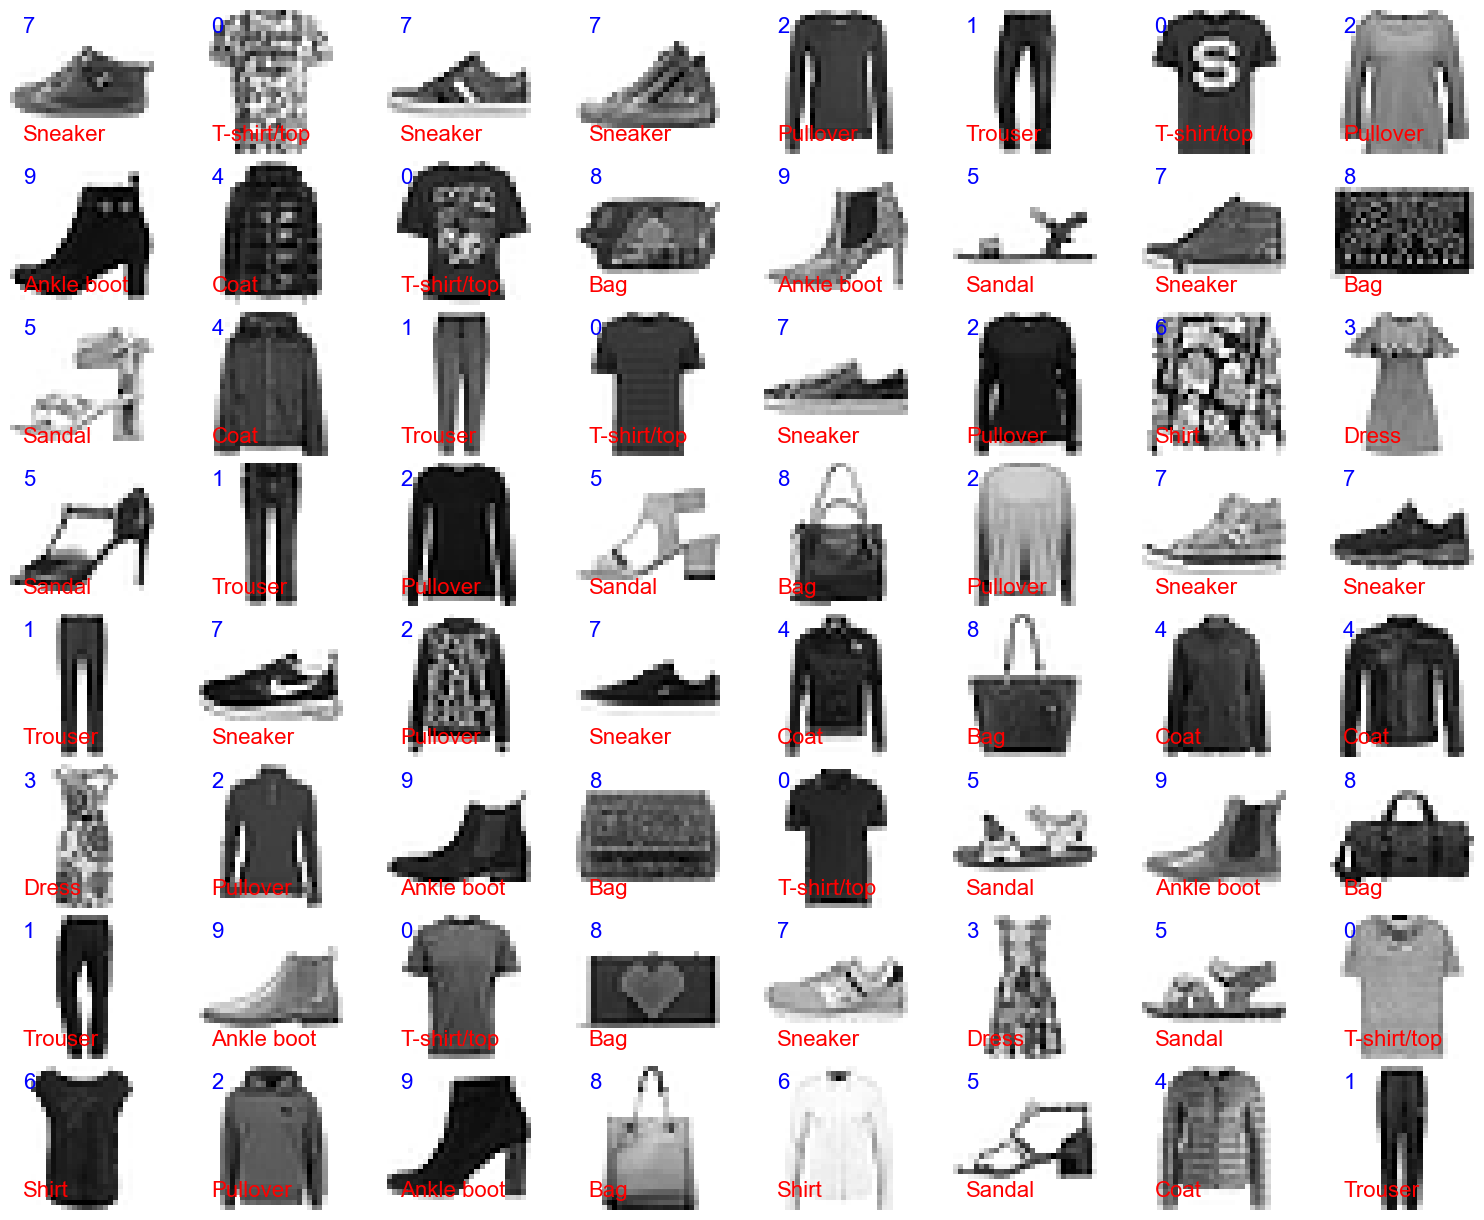

In [18]:
# sample DATA plot: Display a grid of images from the dataset along with their labels

n_rows =  8 # Number of rows to display in the grid
n_cols = 8 # Number of columns

# randomly sample 'n_rows' * n_cols images from the dataset
plot_df = train_df.sample(n = n_rows * n_cols)

#create a new figure for the grid of images with a specified size
fig = plt.figure(figsize  =(15,12))

#Adjust Margins
fig.subplots_adjust(left = 0, right = 1, bottom=0, top = 1, hspace =0.05, wspace = 0.05)
i= 0 
for idx, row in plot_df.iterrows():
    i += 1
    image = row.values[1:].reshape(28,28)

    ax = fig.add_subplot(n_rows, n_cols, i, xticks=[], yticks=[])
    #Display the image on the subplot using a binary colormap
    ax.imshow(image, cmap = plt.cm.binary, interpolation = 'nearest')

    ax.text(2,4, str(row.iloc[0]), color = 'b', fontsize=16)
    #
    ax.text(2,25, class_names[row.iloc[0]], color='r', fontsize  = 16)
#Display the entire grid of images
plt.show()

In [19]:
plot_df.shape

(64, 785)

In [20]:
# X = data_df.drop('Position',axis=1)
# y = data_df['Position']

In [21]:
# data_df.dropna(subset= ('Position'), inplace = True)


In [22]:
for col in train_df.columns:
    unq = train_df[col].unique()
    print(f'{col}, #:{len(unq)}, Values:{unq}')

label, #:10, Values:[2 9 6 0 3 4 5 8 7 1]
pixel1, #:8, Values:[ 0 14  7  3 16  1  4  2]
pixel2, #:17, Values:[ 0  1  3 10  6  2  7  5 16 14 13  9 34 15  4 11 36]
pixel3, #:27, Values:[  0   2   1  10   3   6   4   5   7  56  34  32  16  14  78  25  13   9
   8  52  35  30  23  54 226  15 106]
pixel4, #:65, Values:[  0   1   5   2   3  20  46  87   4  16  12   6  64  36  52  13   7 164
 110  14  92 106 120 105  53  70   9  23  49  25  26  34 121  21  17  10
  41  18  28  80  56 144  22  54  55  50  90 150  19 109  83 132  48  11
  32 145  39  96  15  58   8  68  82 146  86]
pixel5, #:103, Values:[  0   2   4   1   5   3  26  14  39  62  15  16  84   7  88  41  65  17
  35  61  11  21  10   6  18 119 162 106  34  12 217  33  24  37  13 185
  38  71  73   9  40  56  68 171  89  97  91  23  59  42  77 103  29 148
 140  31  45 201   8  95 133  80  44  43  27  20  32  58 123  22 116  66
  60  53 145  85 100  54 210 166 113  19  28 227  30  51  64  96  75  70
  90  82 115 153  36 169  92 110 

In [23]:
train_df.columns

Index(['label', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780',
       'pixel781', 'pixel782', 'pixel783', 'pixel784'],
      dtype='object', length=785)

In [24]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB


In [25]:
# num_cols = data_df.select_dtypes(exclude='object')

In [26]:
# num_cols.info()

In [27]:
X_data = train_df.drop('label',axis=1).to_numpy()
y_data = train_df['label'].to_numpy()


## Split Data in test train

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=TEST_SIZE,stratify = y_data, random_state=RANDOM_STATE)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((48000, 784), (12000, 784), (48000,), (12000,))

In [30]:
X_valid = test_df.drop('label', axis=1).to_numpy()
y_valid = test_df['label'].to_numpy()

In [31]:
type(X_train), type(X_test), type(y_train), type(y_test)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [32]:
X_train.shape, X_test.shape, X_valid.shape, y_train.shape, y_test.shape, y_valid.shape

((48000, 784), (12000, 784), (10000, 784), (48000,), (12000,), (10000,))

In [33]:
# Normalize data beetween [0-1]
X_train = X_train / 255.0
X_test = X_test / 255.0
X_valid = X_valid / 255.0

In [34]:
# # to delete the data which not useful any more
# del train_df, test_df, X_train , X_test, X_valid, X_data, y_data
# gc.collect()
# gc.collect()

In [35]:
# mm = MinMaxScaler()
# X_train = mm.fit_transform(X_train)
# X_test = mm.transform(X_test)

In [36]:
X_train.shape

(48000, 784)

In [37]:
'''Define custom dataset'''
class MNISTDataset(Dataset):
    def __init__(self, X, y):
        super(MNISTDataset, self).__init__()
        self.X = torch.tensor(X, dtype = torch.float32)
        self.y = torch.tensor(y, dtype = torch.long)
    def __len__(self): # length of the data = no. of rows 
        return(len(self.X))

    def __getitem__(self, idx): # give me index of X , y
        return self.X[idx], self.y[idx]
    




In [38]:
train_dataset = MNISTDataset(X_train, y_train)

In [39]:
train_loader = DataLoader(dataset = train_dataset, 
                          batch_size = BATCH_SIZE,
                          shuffle = True
                         )

In [40]:
X_batch , y_batch = next(iter(train_loader))
X_batch.shape, y_batch.shape


(torch.Size([32, 784]), torch.Size([32]))

In [41]:
test_dataset = MNISTDataset(X_test, y_test)

In [42]:
test_loader = DataLoader(dataset = test_dataset, 
                          batch_size = BATCH_SIZE,
                          shuffle = True
                         )
X_batch, y_batch = next(iter(test_loader))
X_batch.shape, y_batch.shape

(torch.Size([32, 784]), torch.Size([32]))

In [43]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [44]:
input_dim = X_train.shape[1]

class Model(nn.Module):
    # Dropout
    #batchNorm
    
    def __init__(self, input_dim):
        super(Model, self).__init__()
        dor1 = 0.1 # pre = 0.1 = .90 .29 # 0.4 = 0.89 0.30  #0.2 = 
        dor2 = 0.2 # .3 .2  .1  .2 .3 = 
        dor3 = 0.3
        dor4 = 0.4
        dor5 = 0.5
        #set1   
        self.layer1 = nn.Linear(input_dim, 392)
        self.actv1 = nn.ReLU()
        self.do1 = nn.Dropout(dor1)
        self.bn1 = nn.BatchNorm1d(392) # layer 1 output 
        
        #set2
        self.layer2 = nn.Linear(392,196)
        self.actv2 = nn.ReLU()
        self.do2 = nn.Dropout(dor3)
        self.bn2 = nn.BatchNorm1d(196)

        #set 3

        self.layer3 = nn.Linear(196,98)
        self.actv3 = nn.ReLU()
        self.do3 = nn.Dropout(dor3)
        self.bn3 = nn.BatchNorm1d(98)
        #set4
        self.layer4 = nn.Linear(98,49)
        self.actv4 = nn.ReLU()
        self.do4 = nn.Dropout(dor3)
        self.bn4 = nn.BatchNorm1d(49)
        #set5
        self.layer5 = nn.Linear(49,24)
        self.actv5 = nn.ReLU()
        self.do5 = nn.Dropout(dor2)
        self.bn5 = nn.BatchNorm1d(24)
        #ouput
        self.layer6 = nn.Linear(24,10)
        

    def forward(self, x):
        #Set1
        x = self.layer1(x)
        x = self.bn1(x)
        
        x = self.actv1(x)
        x = self.do1(x)

        #Set2
        x = self.layer2(x)
        x = self.bn2(x)
        
        x = self.actv2(x)
        x = self.do2(x)
        #Set3
        x = self.layer3(x)
        x = self.bn3(x)
        
        x = self.actv3(x)
        x = self.do3(x)
        #Set4
        x = self.layer4(x)
        x = self.bn4(x)
        
        x = self.actv4(x)
        x = self.do4(x)
        #Set5
        x = self.layer5(x)
        x = self.bn5(x)
        
        x = self.actv5(x)
        x = self.do5(x)
       
        #Set6
        x = self.layer6(x)
        return x
model = Model(input_dim).to(device=device)
print(model)
# model = nn.Sequential(nn.Linear(input_dim, 18),
#                      nn.ReLU(),
#                      nn.Linear(18,4)
#                      ).to(device=device)


Model(
  (layer1): Linear(in_features=784, out_features=392, bias=True)
  (actv1): ReLU()
  (do1): Dropout(p=0.1, inplace=False)
  (bn1): BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Linear(in_features=392, out_features=196, bias=True)
  (actv2): ReLU()
  (do2): Dropout(p=0.3, inplace=False)
  (bn2): BatchNorm1d(196, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer3): Linear(in_features=196, out_features=98, bias=True)
  (actv3): ReLU()
  (do3): Dropout(p=0.3, inplace=False)
  (bn3): BatchNorm1d(98, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer4): Linear(in_features=98, out_features=49, bias=True)
  (actv4): ReLU()
  (do4): Dropout(p=0.3, inplace=False)
  (bn4): BatchNorm1d(49, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer5): Linear(in_features=49, out_features=24, bias=True)
  (actv5): ReLU()
  (do5): Dropout(p=0.2, inplace=False)
  (bn5): BatchNorm1d(24, eps=1

In [45]:
for param in list(model.parameters()):
    print(param.shape)

# Input
#Bias


torch.Size([392, 784])
torch.Size([392])
torch.Size([392])
torch.Size([392])
torch.Size([196, 392])
torch.Size([196])
torch.Size([196])
torch.Size([196])
torch.Size([98, 196])
torch.Size([98])
torch.Size([98])
torch.Size([98])
torch.Size([49, 98])
torch.Size([49])
torch.Size([49])
torch.Size([49])
torch.Size([24, 49])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([10, 24])
torch.Size([10])


In [46]:
modelPath = os.path.join(modelDir, subDir, f'torch_Mnist_{torch.version.cuda}.pth')
modelPath

'./models\\fashion_mnist\\torch_Mnist_None.pth'

In [47]:

#Loss function
#Compilation and # Fit()
loss_fn = nn.CrossEntropyLoss()
#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = ALPHA, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, # learning rate decay
                                                      mode = 'min',
                                                      factor = LR_FACTOR,
                                                      patience = LR_PATIENCE,
 
                                                    min_lr = 1e-5)


# always need to write 
# some lists to collect progress
loss = []
tloss = []
n_epoch = []
acc = []
tacc=[]
best_loss = np.inf
# loop for definedd epochs
for epoch in range(EPOCHS):
    model.train() # set model in training mode 
    epoch_loss = 0
    epoch_acc = 0
    tepoch_loss = 0
    tepoch_acc = 0
   
    for batch_idx, (train_X, train_y) in enumerate(train_loader):
        train_X = train_X.to(device)
        train_y = train_y.to(device)
        predict_proba = model(train_X) # make predict
        batch_loss = loss_fn(predict_proba, train_y) # calculate loss
        epoch_loss += (batch_loss - epoch_loss) / (batch_idx+1) # calculate running mean -> batch loss  for each batch -> then calculate avg loss for epoch
        #curr_loss = loss_fn(predict_proba, train_y)
        # Backpropagation
        optimizer.zero_grad() # Gradient set to Zero
        batch_loss.backward() # calculate loss in backpropagation
        optimizer.step() # move with the steps given by optimizer
        y_pred = predict_proba.argmax(dim=1).cpu().numpy()
        batch_acc = accuracy_score(train_y.cpu().numpy(), y_pred)
        epoch_acc += (batch_acc - epoch_acc)/(batch_idx+1) #accuracy for each batch -> then calculate avg accuracy for epoch
        
    loss.append(epoch_loss.data.item())
    acc.append(epoch_acc)

    model.eval()

    for batch_idx, (test_X, test_y) in enumerate(test_loader):
        test_X, test_y = test_X.to(device), test_y.to(device)
        test_proba = model(test_X)
        batch_loss = loss_fn(test_proba, test_y)
        tepoch_loss += (batch_loss - tepoch_loss)/ (batch_idx + 1)

        y_pred =test_proba.argmax(dim=1).cpu().numpy()
        batch_acc = accuracy_score(test_y.cpu().numpy(), y_pred)
        tepoch_acc += (batch_acc - tepoch_acc)/(batch_idx+1) #accuracy for each batch -> then calculate avg accuracy for epoch
    
    tacc.append(tepoch_acc)
    tloss.append(tepoch_loss.data.item())
    n_epoch.append(epoch)

    #LR Reduction Step
    scheduler.step(tepoch_loss)

    if tepoch_loss < best_loss:
        best_loss = tepoch_loss
        torch.save(model,modelPath)
    
    # loss.append(curr_loss.data.item())
    # y_pred = torch.argmax(predict_proba, dim=1).cpu().numpy()
    # curr_acc = accuracy_score(train_y.cpu().numpy(), y_pred)
    # acc.append(curr_acc)

    # model.eval()# set your model in eval mode
    # test_proba = model(test_X) # make prediction
    # test_loss = loss_fn(test_proba, test_y) # calculate loss
    # tloss.append(test_loss.data.item()) # append for plotting
    
    # y_pred = torch.argmax(test_proba, dim=1).cpu().numpy()
    # test_acc = accuracy_score(test_y.cpu().numpy(),y_pred)
    # tacc.append(test_acc)
    # n_epoch.append(epoch)

    if epoch % 10 == 0:
        print(f'Epoch:{epoch:>5d} | Loss: {epoch_loss:0.5f}/{tepoch_loss:0.5f}')
        print(f' Accuracy: {epoch_acc:0.5f}/{tepoch_acc:0.5f}')
        print(f'LR:{scheduler.get_last_lr()[0]:.5f}')
    

Epoch:    0 | Loss: 0.86421/0.46821
 Accuracy: 0.73356/0.83500
LR:0.00100
Epoch:   10 | Loss: 0.52677/0.39367
 Accuracy: 0.83198/0.86050
LR:0.00100
Epoch:   20 | Loss: 0.50558/0.39484
 Accuracy: 0.83935/0.85992
LR:0.00100
Epoch:   30 | Loss: 0.49525/0.38069
 Accuracy: 0.84081/0.86683
LR:0.00100
Epoch:   40 | Loss: 0.49530/0.38598
 Accuracy: 0.84142/0.86667
LR:0.00100
Epoch:   50 | Loss: 0.49927/0.39567
 Accuracy: 0.84019/0.85783
LR:0.00100
Epoch:   60 | Loss: 0.38299/0.32498
 Accuracy: 0.87813/0.88558
LR:0.00010
Epoch:   70 | Loss: 0.35710/0.32137
 Accuracy: 0.88596/0.88808
LR:0.00010
Epoch:   80 | Loss: 0.34569/0.31259
 Accuracy: 0.88919/0.88933
LR:0.00010
Epoch:   90 | Loss: 0.33291/0.31106
 Accuracy: 0.89308/0.88942
LR:0.00010


In [48]:
loss_df = pd.DataFrame({'epoch':n_epoch ,
                      'loss':loss,
                        'test_loss':tloss,
                        'acc':acc,
                        'test_acc':tacc
                       }
                        )
loss_df.head()

,epoch,loss,test_loss,acc,test_acc
0,0,0.864212,0.468211,0.733562,0.835000
1,1,0.626699,0.434999,0.800396,0.849833
2,2,0.599797,0.447678,0.807500,0.838083
3,3,0.568339,0.441142,0.817771,0.845167
4,4,0.556263,0.448831,0.822313,0.841583


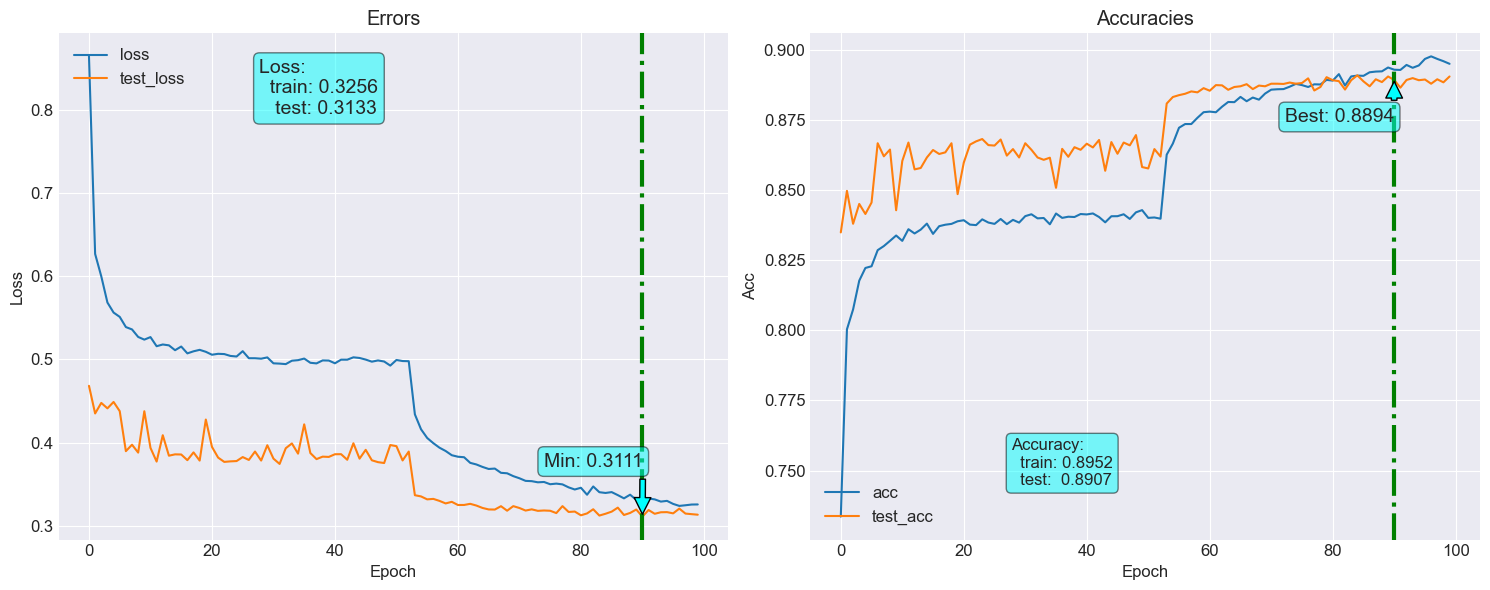

In [49]:
fn_plot_torch_hist(hist_df=loss_df) # drop 0.1 0.2 0.3 0.2 0.1

In [50]:
model

Model(
  (layer1): Linear(in_features=784, out_features=392, bias=True)
  (actv1): ReLU()
  (do1): Dropout(p=0.1, inplace=False)
  (bn1): BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Linear(in_features=392, out_features=196, bias=True)
  (actv2): ReLU()
  (do2): Dropout(p=0.3, inplace=False)
  (bn2): BatchNorm1d(196, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer3): Linear(in_features=196, out_features=98, bias=True)
  (actv3): ReLU()
  (do3): Dropout(p=0.3, inplace=False)
  (bn3): BatchNorm1d(98, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer4): Linear(in_features=98, out_features=49, bias=True)
  (actv4): ReLU()
  (do4): Dropout(p=0.3, inplace=False)
  (bn4): BatchNorm1d(49, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer5): Linear(in_features=49, out_features=24, bias=True)
  (actv5): ReLU()
  (do5): Dropout(p=0.2, inplace=False)
  (bn5): BatchNorm1d(24, eps=1

In [51]:
model1 = torch.load(modelPath, weights_only = False)
model1.eval()

Model(
  (layer1): Linear(in_features=784, out_features=392, bias=True)
  (actv1): ReLU()
  (do1): Dropout(p=0.1, inplace=False)
  (bn1): BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Linear(in_features=392, out_features=196, bias=True)
  (actv2): ReLU()
  (do2): Dropout(p=0.3, inplace=False)
  (bn2): BatchNorm1d(196, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer3): Linear(in_features=196, out_features=98, bias=True)
  (actv3): ReLU()
  (do3): Dropout(p=0.3, inplace=False)
  (bn3): BatchNorm1d(98, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer4): Linear(in_features=98, out_features=49, bias=True)
  (actv4): ReLU()
  (do4): Dropout(p=0.3, inplace=False)
  (bn4): BatchNorm1d(49, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer5): Linear(in_features=49, out_features=24, bias=True)
  (actv5): ReLU()
  (do5): Dropout(p=0.2, inplace=False)
  (bn5): BatchNorm1d(24, eps=1

In [52]:
print(model1)

Model(
  (layer1): Linear(in_features=784, out_features=392, bias=True)
  (actv1): ReLU()
  (do1): Dropout(p=0.1, inplace=False)
  (bn1): BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Linear(in_features=392, out_features=196, bias=True)
  (actv2): ReLU()
  (do2): Dropout(p=0.3, inplace=False)
  (bn2): BatchNorm1d(196, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer3): Linear(in_features=196, out_features=98, bias=True)
  (actv3): ReLU()
  (do3): Dropout(p=0.3, inplace=False)
  (bn3): BatchNorm1d(98, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer4): Linear(in_features=98, out_features=49, bias=True)
  (actv4): ReLU()
  (do4): Dropout(p=0.3, inplace=False)
  (bn4): BatchNorm1d(49, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer5): Linear(in_features=49, out_features=24, bias=True)
  (actv5): ReLU()
  (do5): Dropout(p=0.2, inplace=False)
  (bn5): BatchNorm1d(24, eps=1

In [53]:
# MIN LOSS  = 0.2832 accuracy = 0.9049 for drop =0.2

## DONOT Look Down

In [55]:
# train.csv -> Train, valid dataset
# accuracy -> predcition on test data


In [56]:
# model = tf.keras.Sequential([
#     tf.keras.Input(shape=(2,), name = 'input'), # input layer
#     tf.keras.layers.Dense(5, activation = 'relu', name = 'fc_1'), # Hidden layer called dense in tensorflow
#     tf.keras.layers.Dense(5, activation = 'relu',  name = 'fc_2'),# node called as unit
#     tf.keras.layers.Dense(4, activation = 'relu', name = 'fc_3'),# fully connected layer(Fc)
#     tf.keras.layers.Dense(3, activation = 'relu',  name = 'fc_4'),
#     tf.keras.layers.Dense(2, name = 'output')
    
# ])

In [57]:
 # tf.keras.layers.Dense?


In [58]:
## Unit testing

In [59]:
# prediction = model(X_train[:1]).numpy()
# prediction.sum()

In [60]:
# tf.nn.softmax(prediction).numpy().sum()

In [61]:
# model.summary()

In [62]:
# tf.keras.utils.plot_model(model, "My_first_model.png",
#                          show_shapes = True,show_dtype=True,
#                          show_layer_names = True)

In [63]:
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True) # y_test, y_pred shape should be equal

In [64]:
# loss_fn(y_train[:1], prediction).numpy()

In [65]:
# model.compile(optimizer = 'adam', # optimisation, loss calculation 
#              loss = loss_fn,
#               metrics = ['accuracy']
#              )

In [66]:
# history = model.fit(x = X_train, y = y_train, 
#                     validation_data = [X_test, y_test],
#                     epochs =EPOCHS
#                    )

In [67]:
# hist_df = pd.DataFrame(history.history) #Dictionary
# display(hist_df.head())
# fig, axes = plt.subplots(1,2)
# hist_df.plot(y=['loss', 'val_loss'], ax= axes[0])
# hist_df.plot(y=['accuracy', 'val_accuracy'], ax = axes[1])

In [68]:
# pd.DataFrame(history.history)


In [69]:
# fn_plot_tf_hist(hist_df = hist_df)

In [70]:
# y_pred = model.predict(X_train)
# accuracy_score(y_true= y_train, y_pred = y_pred.argmax(axis=1))

In [71]:
# cm = confusion_matrix(y_true=y_train, y_pred= y_pred.argmax(axis=1))
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1])
# fig,ax = plt.subplots(figsize=(4,4))
# disp.plot(ax=ax, cmap= 'Blues', colorbar = False)
# ax.grid(False)

In [72]:
# y_pred = predict(model, X_test)
# accuracy_score(y_true = y_test, y_pred = y_pred)


In [73]:
#1.1**1000

In [74]:
################### Don't look Down

In [75]:
# rng = np.random.default_rng(seed=RANDOM_STATE)
# def train_weights(train, alpha, n_epoch):
#     errors = []
#     weights = rng.random(data_train.shape[1]) # randomly generated weights
#     m= train.shape[0] # number of samples
#     for epoch in range(n_epoch):
#         sum_error = 0.0
#         for row in train:
#             prediction = predict(row, weights)
#             dz = prediction - row[-1] # a-y
#             sum_error +=  - row[-1] * np.log(prediction) # sum of squared error
#             weights[0] +=  - alpha * dz / m # calculating and adjusting weights by alpha multiplication and  divide with whole row no. to get error for whole set
#             for i in range(len(row) - 1):
#                 weights[i+1] += -alpha * row[i] * dz / m
#         errors.append(sum_error / m)
#     return errors, weights

In [76]:
# def predict(model, X_p):
#     W1, W2, W3, W4, W5 = model['W1'], model['W2'], model['W3'], model['W4'], model['W5']
#     b1,b2,b3,b4,b5 = model['b1'], model['b2'], model['b3'], model['b4'], model['b5']
#     # Layer1 
#     z1 = X_p.dot(W1) + b1 # Aggregation function
#     a1 = fn_actv(z1) ## Activation function
#     # Layer 2
#     z2 = a1.dot(W2) + b2 # Aggregation function
#     a2 = fn_actv(z2) ## Activation function
#     #Layer 3
#     z3 = a2.dot(W3) + b3 # Aggregation function
#     a3 = fn_actv(z3) ## Activation function
#      #Layer 4
#     z4 = a3.dot(W4) + b4 # Aggregation function
#     a4 = fn_actv(z4) ## Activation function
    
#      #Layer 5
#     z5 = a4.dot(W5) + b5 # Aggregation function
#     a5 = softmax(z5) ## Activation function

#     return a5.argmax(axis=1)


In [77]:
# def fn_calculate_loss(model, X_l, y_l):
#     W1, W2, W3, W4, W5 = model['W1'], model['W2'], model['W3'], model['W4'], model['W5']
#     b1,b2,b3,b4,b5 = model['b1'], model['b2'], model['b3'], model['b4'], model['b5']

#     m = X_l.shape[0]
    
#     # Layer1 
#     z1 = X_l.dot(W1) + b1 # Aggregation function
#     a1 = fn_actv(z1) ## Activation function
#     # Layer 2
#     z2 = a1.dot(W2) + b2 # Aggregation function
#     a2 = fn_actv(z2) ## Activation function
#     #Layer 3
#     z3 = a2.dot(W3) + b3 # Aggregation function
#     a3 = fn_actv(z3) ## Activation function
#      #Layer 4
#     z4 = a3.dot(W4) + b4 # Aggregation function
#     a4 = fn_actv(z4) ## Activation function
    
#      #Layer 5
#     z5 = a4.dot(W5) + b5 # Aggregation function
#     a5 = softmax(z5) ## Activation function
#     data_loss = -(y_l * np.log(a5) + (1 - y_l)*np.log(1-a5)).sum()
#     return data_loss / m

In [78]:
# def fn_actv(z):
#     return np.tanh(z)

# def fn_actv_prime(z): # Differentiation of Tanh()
#     return 1 - (np.tanh(z))**2

In [79]:
# fn_actv(np.array([[-1,0,1],[-np.inf,0,np.inf]]))

In [80]:
# def predict():
#     z = 1
#     return sigmoid(z) # stepwise Activation Function
        

In [81]:
# def fn_loss_calculate_loss():
#     pass

## Split DATA in Test Train

In [83]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE,stratify = y, random_state=RANDOM_STATE)
# X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [84]:
# def build_model(param, X_t, y_t, n_epochs= EPOCHS, alpha = ALPHA):
#     '''
#     5-5-4-3
#     '''
#     # get dimensions for weights init
#     m = X_t.shape[0]
    
#     # initialize weights
#     W1 = rng.random((param[0], param[1]), dtype = np.float32) / np.sqrt(param[0])
#     W2 = rng.random((param[1], param[2]), dtype = np.float32)/np.sqrt(param[1])
#     W3 = rng.random((param[2], param[3]), dtype = np.float32)/np.sqrt(param[2]) 
#     W4 = rng.random((param[3], param[4]), dtype = np.float32)/np.sqrt(param[3])
#     W5 = rng.random((param[4], param[5]), dtype = np.float32)/np.sqrt(param[4])
    
#     # initialize bias
#     b1 = np.zeros((1,param[1]), dtype = np.float32)
#     b2 = np.zeros((1,param[2]), dtype = np.float32)
#     b3 = np.zeros((1,param[3]), dtype = np.float32)
#     b4 = np.zeros((1,param[4]), dtype = np.float32)
#     b5 = np.zeros((1,param[5]), dtype = np.float32)

#     # print(W1.shape, W2.shape, W3.shape, W4.shape, W5.shape)
#     # print(b1.shape, b2.shape, b3.shape, b4.shape, b5.shape)
    
#     curr_loss = 0
#     loss = []
#     # loss_hist = {}
#     epoch = []
#     for i in range(n_epochs):
#         ### Forwards propagation
#         # Layer1 
#         z1 = X_t.dot(W1) + b1 # Aggregation function
#         a1 = fn_actv(z1) ## Activation function
#         # Layer 2
#         z2 = a1.dot(W2) + b2 # Aggregation function
#         a2 = fn_actv(z2) ## Activation function
#     #Layer 3
#         z3 = a2.dot(W3) + b3 # Aggregation function
#         a3 = fn_actv(z3) ## Activation function
#          #Layer 4
#         z4 = a3.dot(W4) + b4 # Aggregation function
#         a4 = fn_actv(z4) ## Activation function

#          #Layer 5
#         z5 = a4.dot(W5) + b5 # Aggregation function
#         a5 = softmax(z5) ## Activation function

#     # # Layer2
#     #     z2 = a1.dot(W2) + b2 # Aggregation function
#     #     a2 = sigmoid(z2)# Activation function

#         ### Back Propagation
#         ## Layer 5
#         dz5 = a5 - y_t # y should be of shape (1,m)
        
#         dW5 = (a4.T).dot(dz5)
#         assert(W5.shape == dW5.shape), f'Shape: W5- {W5.shape} and dW5-{dW5.shape}'
#         db5 = np.sum(dz5, axis = 0, keepdims =True)
#         assert(b5.shape == db5.shape), f'Shape: b5- {b5.shape} and db5-{db5.shape}'
#         da4 = dz5.dot(W5.T)
#         assert(a4.shape == da4.shape), f'Shape: a4-{a4.shape} and da4-{da4.shape}'
#         # layer 4
#         dz4 = da4 * fn_actv_prime(z4)
#         dW4 = (a3.T).dot(dz4)
#         assert(W4.shape == dW4.shape),f'Shape: W4- {W4.shape} and dW4-{dW4.shape}'
#         db4 = np.sum(dz4, axis = 0, keepdims =True)
#         assert(b4.shape == db4.shape), f'Shape: b4- {b4.shape} and db4-{db4.shape}'
#         da3 = dz4.dot(W4.T)
#         assert(a3.shape == da3.shape), f'Shape: a3-{a3.shape} and da3-{da3.shape}'

#         # layer3
#         dz3 = da3 * fn_actv_prime(z3)
#         dW3 = (a2.T).dot(dz3)
#         assert(W3.shape == dW3.shape),f'Shape: W3- {W3.shape} and dW3-{dW3.shape}'
#         db3 = np.sum(dz3, axis = 0, keepdims =True)
#         assert(b3.shape == db3.shape), f'Shape: b3- {b3.shape} and db3-{db3.shape}'
#         da2 = dz3.dot(W3.T)
#         assert(a2.shape == da2.shape), f'Shape: a2-{a2.shape} and da2-{da2.shape}'

#         #Layer2
#         dz2 = da2 * fn_actv_prime(z2)
#         dW2 = (a1.T).dot(dz2)
#         assert(W2.shape == dW2.shape), f'Shape: W2- {W2.shape} and dW2-{dW2.shape}'
#         db2 = np.sum(dz2, axis = 0, keepdims =True)
#         assert(b2.shape == db2.shape), f'Shape: b2- {b2.shape} and db2-{db2.shape}'
#         da1 = dz2.dot(W2.T)    
#         assert(a1.shape == da1.shape), f'Shape: a1-{a1.shape} and da1-{da1.shape}'

#         #layer1
#         dz1 = da1 *fn_actv_prime(z1)
#         assert(z1.shape == dz1.shape),f'Shape: z1-{z1.shape} and dz1-{dz1.shape}'
#         dW1 = (X_t.T).dot(dz1)
#         assert(W1.shape == dW1.shape), f'Shape: W1-{W1.shape} and dW1-{dW1.shape}'
#         db1 = np.sum(dz1, axis = 0, keepdims = True)
#         assert(b1.shape == db1.shape), f'Shape: b1-{b1.shape} and db1-{db1.shape}' # assert kind of exception handling
#                 # if shape don't match it fire error, if true do nothing


        
        


        
        
        
        

#         ## Gradient Update
#         W1 += -alpha *dW1 /m
#         W2 += -alpha *dW2 /m
#         W3 += -alpha *dW3 /m
#         W4 += -alpha *dW4 /m
#         W5 += -alpha *dW5 /m
#         b1 += -alpha *db1 /m
#         b2 += -alpha *db2 /m
#         b3 += -alpha *db3 /m
#         b4 += -alpha *db4 /m
#         b5 += -alpha *db5 /m

#         model = {'W1': W1,'W2':W2,'W3':W3, 'W4':W4, 'W5': W5,
#                 'b1': b1, 'b2':b2, 'b3':b3, 'b4':b4, 'b5':b5                
#                 }
        
#         if i%100==0:
#             curr_loss = fn_calculate_loss(model, X_t, y_t)
#             loss.append(curr_loss)
#             epoch.append(i)
            
#         if i%1000 == 0:
#            print(f'Loss after {i:>5d} epochs : {curr_loss:0.5f}')

#     # printing the error reduction curve
#     loss_hist['epoch'] = epoch
#     loss_hist['loss'] = loss
#     fig, ax = plt.subplots()
#     ax.plot(loss)
    
    
#     return model
    

In [85]:
# loss_hist = {}
# layer_params = [X_train.shape[1], 50,50,40,30,y_train.shape[1]]#[2,5,5,4,3,2]
# #y_train = y_train.reshape(-1,1)
# #y_train.shape

In [86]:
# y_train = y_train.reshape(-1,1)
# y_train.shape

In [87]:
# loss_hist = {}


In [88]:
# model = build_model(layer_params,X_train,y_train )

In [89]:
# pd.DataFrame(loss_hist).plot(x='epoch', y='loss');

In [90]:
# y_pred = predict(model, X_train)
# accuracy_score(y_true = y_train.argmax(axis=1), y_pred = y_pred)


In [91]:
# cm = confusion_matrix(y_true=y_train.argmax(axis=1), y_pred= y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1])
# fig,ax = plt.subplots(figsize=(4,4))
# disp.plot(ax=ax, cmap= 'Blues', colorbar = False)
# ax.grid(False)

In [92]:
# y_pred = predict(model, X_test)
# accuracy_score(y_true = y_test.argmax(axis=1), y_pred = y_pred)


In [93]:
# cm = confusion_matrix(y_true=y_test.argmax(axis=1), y_pred= y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1])
# fig,ax = plt.subplots(figsize=(4,4))
# disp.plot(ax=ax, cmap= 'Blues', colorbar = False)
# ax.grid(False)

In [94]:
# def fn_plot_decision_boundary(model, X_tr, y_tr, X_ts, y_ts):
#     fig, ax = plt.subplots(figsize =(8,5))
#     dm = 0.05
#     # Min and Max Along Two Axis 
#     x_min, x_max = X_tr[:,0].min(), X_tr[:,0].max()
#     y_min, y_max = X_tr[:,1].min(), X_tr[:,1].max()

#     display(x_min, x_max)
#     display(y_min, y_max)

#     ## generate a mesh grid
#     xx, yy = np.meshgrid(np.arange(x_min, x_max, dm), 
#                     np.arange(y_min, y_max, dm))
#     display(xx.shape,yy.shape)
#     # ravel means 2d -> 1d
    
#     XX = np.c_[xx.ravel(), yy.ravel()]
#     display(XX.shape)
    
#     y_pred = predict(model,XX)
#     display(y_pred.shape)
#     Z = np.array(y_pred).reshape(xx.shape)
#     ax.contourf(xx, yy, Z, alpha = 0.8 , cmap = plt.cm.Paired)
#     ax.scatter(X_tr[:,0], X_tr[:,1], c = y_tr.argmax(axis=1), edgecolors = 'k', cmap=CMAP)
#     ax.scatter(X_ts[:,0], X_ts[:,1], c = y_ts.argmax(axis=1), edgecolors = 'k', cmap=CMAP, marker ='*')


In [95]:
# fn_plot_decision_boundary(model, X_train, y_train, X_test, y_test)